In [1]:
!pip install gdown==v4.6.0

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import stats
from itertools import combinations
from sklearn.metrics import roc_curve, auc, f1_score
from datetime import datetime
import pytz
from scipy.stats import ttest_ind
import seaborn as sns
import math
import gdown

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Neural Network build and train

In [2]:
url_id  = '1FcWMzbENNZZt424kW4x4yLzDS4D5uqBv'
url = 'https://drive.google.com/uc?id=' + url_id
input_csv_file = 'dummy_tRNAs_triplets.pkl'

gdown.download(url, input_csv_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FcWMzbENNZZt424kW4x4yLzDS4D5uqBv
To: /kaggle/working/dummy_tRNAs_triplets.pkl
100%|██████████| 56.1M/56.1M [00:00<00:00, 129MB/s]


'dummy_tRNAs_triplets.pkl'

In [3]:
def decompress_matrix(indexes_array):

    L = len(indexes_array)

    decompressed_matrix = np.zeros((L, L))

    for row, pos in enumerate(indexes_array):
        if pos != -1:
            decompressed_matrix[row, pos] = 1
        else:
            pass

    return np.array(decompressed_matrix, dtype=np.int8)

def center_pad_matrix(compressed_structure, max_len, padding_value=-1):
    ''' Takes the comrpessed structure (as an array of contacts),
    and padds the structure with -1s (single stranded bases),
    leaving the structure in the middle. As a consequence of this, unpaired
    5' and 3' will provide no information'''
    
    structure_len = len(compressed_structure)
    temp_structure = compressed_structure.copy()
    if structure_len < max_len:
        to_pad = max_len-structure_len
        
        if to_pad % 2 == 0:
            left_pad = int(to_pad/2)
            right_pad = int(left_pad)
        else:
            left_pad = int(to_pad // 2)
            right_pad = int(to_pad // 2 + 1)
        
        # we have to shift all the indexes left_pad positions to the right
        for i, index in enumerate(compressed_structure):
            if index != -1:
                temp_structure[i] += left_pad
            else:
                pass

        temp_structure = [padding_value] * left_pad + temp_structure + [padding_value] * right_pad
        
    return temp_structure


def preprocess_triplets(dot_bracket_A, dot_bracket_P, dot_bracket_N):
    """
    Given the dot_bracket_structures of corresponding to the three images,
    load and
    preprocess them.
    """

    return (
        dot_bracket_A,
        dot_bracket_P,
        dot_bracket_N,
    )


'''layers.Conv2D(32, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
layers.MaxPooling2D((2, 2)),'''

def create_cnn_model(target_shape, embedding_size=256):
    
    inputs = layers.Input(shape=target_shape)
    conv2d_1 = layers.Conv2D(32, (7, 7), activation='relu')(inputs)
    maxpooling_1 = layers.MaxPooling2D((2, 2))(conv2d_1)
    conv2d_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(maxpooling_1)
    maxpooling_2 = layers.MaxPooling2D((2, 2))(conv2d_2)
    flatten = layers.Flatten()(maxpooling_2)
    dense_1 = layers.Dense(embedding_size, activation='relu')(flatten)
    emb_vector = layers.Dense(embedding_size, activation='relu')(dense_1)

    model = Model(inputs=inputs, outputs=emb_vector)

    return model

def square_dist(emb1, emb2):
    
    distance = tf.reduce_sum(tf.square(emb1 - emb2), -1).numpy()[0]
    return distance

In [4]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.3):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        loss *= 100
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [5]:
df = pd.read_pickle(input_csv_file)

max_len = max(max(df['structure_A'].apply(len)),
              max(df['structure_P'].apply(len)),
              max(df['structure_N'].apply(len)))

In [6]:
# Pading

tqdm.pandas(desc='Padding Anchor structures')
df['structure_A'] = df.progress_apply((lambda x: center_pad_matrix(x['structure_A'], max_len)), axis =1)
tqdm.pandas(desc='Padding Positive structures')
df['structure_P'] = df.progress_apply((lambda x: center_pad_matrix(x['structure_P'], max_len)), axis =1)
tqdm.pandas(desc='Padding Negative structures')
df['structure_N'] = df.progress_apply((lambda x: center_pad_matrix(x['structure_N'], max_len)), axis =1)

# Decompression
tqdm.pandas(desc='Decompressing Anchor structures')
df["structure_A"] = df['structure_A'].progress_apply(decompress_matrix)
tqdm.pandas(desc='Decompressing Positive structures')
df["structure_P"] = df['structure_P'].progress_apply(decompress_matrix)
tqdm.pandas(desc='Decompressing Negative structures')
df["structure_N"] = df['structure_N'].progress_apply(decompress_matrix)

Decompressing Negative structures: 100%|██████████| 36000/36000 [00:04<00:00, 7608.11it/s]


In [7]:
anchor_structures = np.array([val for val in df['structure_A']])
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_structures)

positive_structures = np.array([val for val in df['structure_P']])
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_structures)

negative_structures = np.array([val for val in df['structure_N']])
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_structures)

# Build the dataset
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

del(anchor_dataset)
del(positive_dataset)
del(negative_dataset)

# Split our dataset in train and validation.
train_dataset = dataset.take(round(df.shape[0] * 0.9))
val_dataset = dataset.skip(round(df.shape[0] * 0.9))

batch_size = 32

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [8]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


# visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [9]:
# Example usage:
target_shape = (max_len, max_len) + (1,)  # Change this to your desired input shape

In [10]:
# Create a MirroredStrategy.
# strategy = tf.distribute.MirroredStrategy()

# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# # Open a strategy scope.
# with strategy.scope():
embedding = create_cnn_model(target_shape)

anchor_input = layers.Input(name="anchor", shape=target_shape)
positive_input = layers.Input(name="positive", shape=target_shape )
negative_input = layers.Input(name="negative", shape=target_shape )

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


siamese_model = SiameseModel(siamese_network, margin=2)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001, beta_1=0.90), weighted_metrics=[])

In [11]:
embedding.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 248, 248, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 242, 242, 32)      1600      
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 121, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 60, 60, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 230400)            0     

In [12]:
callback = EarlyStopping(monitor='val_loss',
                         patience=10,
                         restore_best_weights=True,
                         verbose = 1)

In [13]:
history = siamese_model.fit(train_dataset, epochs=50,
                            validation_data=val_dataset,
                            callbacks=[callback])

Epoch 1/50
1013/1013 [==============================] - 83s 77ms/step - loss: 5.8588 - val_loss: 1.8673
Epoch 2/50
1013/1013 [==============================] - 72s 71ms/step - loss: 1.4301 - val_loss: 2.1343
Epoch 3/50
1013/1013 [==============================] - 72s 71ms/step - loss: 0.8166 - val_loss: 4.7997
Epoch 4/50
1013/1013 [==============================] - 72s 71ms/step - loss: 0.9991 - val_loss: 2.1565
Epoch 5/50
1013/1013 [==============================] - 72s 71ms/step - loss: 0.4621 - val_loss: 2.8678
Epoch 6/50
1013/1013 [==============================] - 72s 71ms/step - loss: 0.5173 - val_loss: 1.4968
Epoch 7/50
1013/1013 [==============================] - 72s 71ms/step - loss: 0.5105 - val_loss: 2.3207
Epoch 8/50
1013/1013 [==============================] - 72s 71ms/step - loss: 0.5872 - val_loss: 1.3463
Epoch 9/50
1013/1013 [==============================] - 72s 71ms/step - loss: 0.3890 - val_loss: 2.7217
Epoch 10/50
1013/1013 [==============================] - 72s 71m

# bpRNA dataset testing

In [14]:
# @title Download structures datataset

url_id = '1wHL8oi0-4oRv3pfRu5g9QcJOsddieN6O' # @param {type:"string"}
url = 'https://drive.google.com/uc?id=' + url_id

output_file = 'unpaired_structures.tsv'
gdown.download(url, output_file, quiet=False)
# Load the CSV file into a pandas DataFrame
df = pd.read_csv(output_file, sep='\t')

Downloading...
From: https://drive.google.com/uc?id=1wHL8oi0-4oRv3pfRu5g9QcJOsddieN6O
To: /kaggle/working/unpaired_structures.tsv
100%|██████████| 352k/352k [00:00<00:00, 109MB/s]


In [15]:
# @title Download and load Rfam dataframe

url_id = "1xnkcwYhzu68IxRufv3gd4xACgd8sBEt9" # @param {type:"string"}
url = 'https://drive.google.com/uc?id=' + url_id

output_file = 'rfam_df.tsv'
gdown.download(url, output_file, quiet=False)

# Load the Pickle file into a Pandas DataFrame
rfam_df = pd.read_csv(output_file,
                      comment='#', engine='python', header=0)

Downloading...
From: https://drive.google.com/uc?id=1xnkcwYhzu68IxRufv3gd4xACgd8sBEt9
To: /kaggle/working/rfam_df.tsv
100%|██████████| 22.4k/22.4k [00:00<00:00, 31.2MB/s]


In [16]:
rfam_df['target3'].fillna('', inplace=True)
rfam_df['target4'].fillna('', inplace=True)
rfam_df['target5'].fillna('', inplace=True)

# Combine values in target1 to target5 columns into a single column called 'description'
rfam_df['description'] = rfam_df[['target1',
                                  'target2',
                                  'target3',
                                  'target4',
                                  'target5']
                                 ].apply(lambda row: ' '.join(row), axis=1)

# Strip whitespaces from the sides of the resulting column
rfam_df['description'] = rfam_df['description'].str.strip()

# Drop the original target1 to target5 columns if you want
rfam_df = rfam_df.drop(['target1', 'target2', 'target3', 'target4', 'target5'], axis=1)


all_RNP_set = set(df[df['RNA_type'] == 'RNP']['rna_name'])
rfam_RNP_set = set(list(rfam_df['query_name']))
not_in_rfam = all_RNP_set - rfam_RNP_set

# Get the indices of rows with the highest score in each group
idx_max = rfam_df.groupby('query_name')['score'].idxmax()

# Filter the original DataFrame using the obtained indices
rfam_df = rfam_df.loc[idx_max]

## Functions definition

In [17]:
#@title Function definitions

def dot_bracket_to_matrix_2(dot_bracket):
    L = len(dot_bracket)
    contact_matrix = np.zeros((L, L))

    look_for = [('(',')'),('[',']'),('{','}'),('<','>'), ('A', 'a')]

    for open, close in look_for:
        for i_x, base_x in enumerate(dot_bracket):
            if base_x == open:

                # Finding first closed bracket ahead
                first_closing = dot_bracket[i_x:].find(close)

                # Counting the number of ( between subject ( and first )
                N = dot_bracket[i_x:first_closing+i_x].count(open)

                # To find the ) matching the subject (, we have to search
                # for the (N)th ) ahead of our (
                c = 0
                i_match = 0
                for i_y, base_y in enumerate(dot_bracket[i_x+first_closing:]):
                    if base_y == open:
                        N += 1

                    if base_y == close:
                        c += 1
                        if c == N:

                            i_match =  i_x + first_closing + i_y
                            break

                contact_matrix[i_x, i_match] = 1
                contact_matrix[i_match, i_x] = 1

            else:
                continue

    return contact_matrix.astype(np.uint8)


def filter_matrices(row, M):
    mat1 = row['matrix_structure']
    return mat1.shape[0] >= M or mat1.shape[1] >= M


def pad_matrix(matrix, M):
    # Get the dimensions of the input matrix
    original_shape = matrix.shape

    # Calculate the padding for each side
    pad_amount_top = (M - original_shape[0]) // 2
    pad_amount_bottom = M - original_shape[0] - pad_amount_top

    pad_amount_left = (M - original_shape[1]) // 2
    pad_amount_right = M - original_shape[1] - pad_amount_left

    # Pad the matrix symmetrically on each side with zeros
    padded_matrix = np.pad(matrix, ((pad_amount_top, pad_amount_bottom), (pad_amount_left, pad_amount_right)), mode='constant', constant_values=0)

    return padded_matrix


def cos_similarity(row):
  cosine_similarity = metrics.CosineSimilarity()
  emb_1 = row['embedding_vector_1']
  emb_2 = row['embedding_vector_2']
  cos_similarity = cosine_similarity(emb_1, emb_2).numpy()

  return cos_similarity


def square_dist(emb1, emb2):
  distance = tf.reduce_sum(tf.square(emb1 - emb2), -1).numpy()[0]

  return distance

def euclidean_distance(row):
    emb_1 = row['embedding_vector_1']
    emb_2 = row['embedding_vector_2']

    return tf.norm(emb_1 - emb_2).numpy()


def get_corr_matrix(df, metrics=['cosine_similarity',
                                 'square_distance',
                                 'euclidean_distance']):

  return df[metrics].corr()


def length_average(A, B):
    len_A = len(A)
    len_B = len(B)
    average = (len_A + len_B) / 2

    return average

def relative_difference(A, B):
    len_A = len(A)
    len_B = len(B)
    average = (len_A + len_B) / 2
    relative_difference = abs(len_A - len_B) / average * 100

    return relative_difference


def plot_ROC(binary_pair_type, score):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_pair_type, score)
    roc_auc = auc(fpr, tpr)

    print('AUC =', str(round(roc_auc, 2)), '\n')



    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def compute_f1_score(binary_pair_type, score, threshold):
  y_pred = (score > threshold).astype(int)
  f1 = f1_score(binary_pair_type, y_pred)

  return round(f1, 4)


def plot_distribution(x, df, pairing_type='pair_type2'):

    plt.figure(figsize=(12, 6))
    xlim = df[x].max()
    binwidth = xlim/100
    plt.xlim(0, xlim)
    title = 'Frequency Distribution of ' + x.capitalize()
    sns.set(style="whitegrid")

    # Create a histogram with colored bins based on pair_type
    g = sns.histplot(data=df, x=x, hue=pairing_type, element='step', stat='density', common_norm=False, binwidth=binwidth)

    # Set plot labels and title
    g.set(xlabel=x.capitalize(), ylabel='Frequency', title=title)

    # Move the legend outside the plot
    sns.move_legend( g, "upper left", bbox_to_anchor=(1, 1), title='Pair type')

    # Display the plot
    plt.show()


def create_pairs_categories1(row, RNA_type):
  if row['group_1'] == RNA_type and row['group_2'] == RNA_type:
    return RNA_type+'-'+RNA_type
  else:
    return 'random'


def create_pairs_categories2(row, RNA_type):
  if row['group_1'] == RNA_type and row['group_2'] == RNA_type:
    return RNA_type+'-'+RNA_type
  elif (row['group_1'] == RNA_type and row['group_2'] == 'random') or \
       (row['group_1'] == 'random' and row['group_2'] ==  RNA_type):
       return RNA_type+'-'+'random'
  else:
    return 'random-random'

def create_pairs_categories3(row, RNA_type):
  if row['rna_class_1'] == row['rna_class_2']:
    return row['rna_class_1']
  elif row['rna_class_1'] == 'random' or \
    row['rna_class_2'] == 'random':
    return 'random'
  else:
    return 'Different class RNAse P pair'

def create_pairs_categories4(row, RNA_type):

  if row['rna_class_1'] == 'random' or \
  row['rna_class_2'] == 'random':
    return 'Random pair'
  elif row['rna_class_1'] == 'Unknown RNAse P class' or \
  row['rna_class_2'] == 'Unknown RNAse P class':
    return 'Unknown class RNAse P pair'
  elif row['rna_class_1'] == row['rna_class_2']:
    return 'Same class RNAse P pair'
  elif row['group_1'] == 'RNP' and row['group_2'] == 'RNP':
    return 'Different class RNAse P pair'
  else:
    return 'Random pair'


def create_pairs_binary(row, RNA_type):
  if row['group_1'] == RNA_type and row['group_2'] == RNA_type:
    return 1
  else:
    return 0


def get_alignment_score(seq1, seq2):
  seq_pair = needle.NeedlemanWunsch(seq1, seq2)
  seq_pair.align()

  return seq_pair.get_score()


def model_stadistics(df, metric, metric_type, RNA_type, pairing_type='pair_type2', f1_threshold=0.5):

  target_pair = RNA_type+'-'+RNA_type

  target_metric_serie = df.loc[
      df.pair_type ==  target_pair, metric]

  random_metric_serie = df.loc[
      df.pair_type ==  'random', metric]

  target_metric_mean = target_metric_serie.mean()
  random_metric_mean = random_metric_serie.mean()

  print(target_pair + ' pairs mean ' + metric + ' =', round(target_metric_mean, 3))
  print('Random pairs mean'  + metric + ' =', round(random_metric_mean, 3))

  # Perform the t-test
  t_statistic, p_value = ttest_ind(target_metric_serie,
                                  random_metric_serie,
                                  equal_var=False)

  if p_value == 0:
    print(f"P-value < 1e-324")
  else:
    print(f"P-value = {p_value}")


  if metric_type == 'similarity':
    score = df[metric]
    use_f1_threshold = f1_threshold
  elif metric_type == 'distance':
    score = 1/df[metric]
    use_f1_threshold = 1/f1_threshold

  else:
    raise ValueError("Invalid metric_type")

  f1 = compute_f1_score(df['binary_pair_type'],
                      score,
                      threshold = use_f1_threshold)

  print('F1 Score =', f1, '(threshold = '+str(f1_threshold)+')')

  plot_ROC(df['binary_pair_type'], score)

  print('\n')

  plot_distribution(x=metric, df=df, pairing_type=pairing_type)


def get_RNP_class(row):

  RNA_type = row['RNA_type']

  if RNA_type == 'random':
    return 'random'

  else:
    pass

  rna_name = row['rna_name']

  if rna_name in not_in_rfam:
    return 'Unknown RNAse P class'
  else:
    RNP_class = rfam_df.loc[rfam_df['query_name'] == rna_name].iloc[0]['description']
    return RNP_class

df['rna_class'] = df.apply(get_RNP_class, axis = 1)


def windows_square_dist(embedding_vector_windows_1, embedding_vector_windows_2):

  structure_1_windows_n = len(embedding_vector_windows_1)
  structure_2_windows_n = len(embedding_vector_windows_2)
  if structure_1_windows_n < structure_2_windows_n:
    embedding_vector_windows_A = embedding_vector_windows_1
    embedding_vector_windows_B = embedding_vector_windows_2
  else:
    embedding_vector_windows_A = embedding_vector_windows_2
    embedding_vector_windows_B = embedding_vector_windows_1

  distances = []
  
  for embedding_vector_A in embedding_vector_windows_A:
    window_A_distances = []
    for embedding_vector_B in embedding_vector_windows_B:
      distance = square_dist(embedding_vector_A, embedding_vector_B)
      window_A_distances.append(distance)

    distances.append(window_A_distances)

  return distances

## SS_Windower function definitions

In [18]:
#@title Function definitions

def dot_bracket_to_matrix_2(dot_bracket):
    L = len(dot_bracket)
    contact_matrix = np.zeros((L, L))

    look_for = [('(',')'),('[',']'),('{','}'),('<','>'), ('A', 'a')]

    for open, close in look_for:
        for i_x, base_x in enumerate(dot_bracket):
            if base_x == open:

                # Finding first closed bracket ahead
                first_closing = dot_bracket[i_x:].find(close)

                # Counting the number of ( between subject ( and first )
                N = dot_bracket[i_x:first_closing+i_x].count(open)

                # To find the ) matching the subject (, we have to search
                # for the (N)th ) ahead of our (
                c = 0
                i_match = 0
                for i_y, base_y in enumerate(dot_bracket[i_x+first_closing:]):
                    if base_y == open:
                        N += 1

                    if base_y == close:
                        c += 1
                        if c == N:

                            i_match =  i_x + first_closing + i_y
                            break

                contact_matrix[i_x, i_match] = 1
                contact_matrix[i_match, i_x] = 1

            else:
                continue

    return contact_matrix.astype(np.uint8)


def remove_pseudoknots(db):
  look_for = [('[',']'),('{','}'),('<','>'), ('A', 'a')]

  for open, close in look_for:

    db = db.replace(open, '.')
    db = db.replace(close, '.')

  return db


def draw_cuts(before, windows=[]):

  fig = plt.figure(figsize=(15, 10))

  plt.rcParams['figure.figsize'] = [8.0, 6.0]
  cg1 = forgi.load_rna(before, allow_many=False)
  fvm.plot_rna(cg1, text_kwargs={"fontweight":"black"}, lighten=0.7,
              backbone_kwargs={"linewidth":3})
  plt.title('Before')

  plt.show()

  fig = plt.figure(figsize=(15, 10))

  n_rows = int(math.ceil(len(windows) / 2))

  for id, window in enumerate(windows):
    
    plt.subplot(n_rows, 2, id+1)
    plt.rcParams['figure.figsize'] = [8.0, 6.0]
    cg = forgi.load_rna(window, allow_many=False)
    fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.7,
                backbone_kwargs={"linewidth":3})
    plt.title('Cut #' + str(id+1))

  plt.show()


def plot_array(array, x_cut=None, reverse_colors=False):
  ''' Plots a bar showing the different values along the 1D array with
  different colors '''

  colors = plt.cm.viridis(array)

  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(10, 1))

  # Plot the color bar
  cax = ax.matshow([array], cmap='viridis', aspect='auto')

  if reverse_colors:
    cax.set_cmap('viridis_r')

  # Remove y-axis ticks and labels
  ax.set_yticks([])

  # Add color bar
  fig.colorbar(cax, orientation='horizontal', aspect=50)
  if x_cut:
    ax.axvline(x=x_cut, color='red', linestyle='dashed')

  # Show the plot
  plt.show()


def find_one(arr):
  ''' Given an array, it returns i where arr[i] == 1 '''
  
  if np.any(arr == 1):
      return np.argmax(arr)
  else:
      return np.nan


def cut_structure(db, x_cut, y_cut):
  ''' Given a dotbracket structure and two coordinates of two paired bases
  inside a stem, it returns two slices of the structure that results from
  cutting it in that particular location
  '''

  first = min(x_cut, y_cut)
  last = max(x_cut, y_cut)

  cut1 = db[:first+1] + db[last:]
  cut2 = db[first+1:last]

  return cut1, cut2

def get_slices_length_difs(db):
  ''' This function creates a slices_length_difs, which is an array that shows
  what would be the difference of the length of the resulting slices when
  cutting the secondary structure in each position.
  '''

  matrix = dot_bracket_to_matrix_2(db)

  half_matrix = matrix.copy()
  half_matrix[np.tril_indices_from(half_matrix, k=-1)] = 0

  slices_length_difs = np.full(matrix.shape[0], np.nan)

  for x_index, x in enumerate(half_matrix):

    y_index = find_one(x)

    if not(np.isnan(y_index)):
      first = min(x_index, y_index)
      last = max(x_index, y_index)
      cut1 = db[:first+1] + db[last:]
      cut2 = db[first+1:last]
      dist = abs(len(cut1)-len(cut2))
      slices_length_difs[x_index] = dist

  return slices_length_difs


def get_best_cut_coords(db, slices_length_difs):
  ''' Using the slices_length_difs, it returns the x and y coordinates of the
  structure, where the cut produce the smaller difference between the resulting
  slices '''

  matrix = dot_bracket_to_matrix_2(db)

  # Find indices where the values are not equal to np.nan
  valid_indices =  np.where(~np.isnan(slices_length_difs))[0]

  # # Find the index of the minimum value among the valid indices
  cut_x_coord = valid_indices[np.argmin(slices_length_difs[valid_indices])]
  cut_y_coord = find_one(matrix[cut_x_coord])

  return (cut_x_coord, cut_y_coord)


def get_shift_cut_distances(db, slices_length_difs):
  ''' Given a dot bracket structure, it creates an array that maps the
  difference in the length of all possible dobuble strand cuts in stems of the 
  structure
  '''

  (x_best, y_best) = get_best_cut_coords(db, slices_length_difs)

  matrix = dot_bracket_to_matrix_2(db)

  half_matrix = matrix.copy()
  half_matrix[np.tril_indices_from(half_matrix, k=-1)] = 0

  shift_cut_distances = np.full(matrix.shape[0], np.nan)

  for x_index, x in enumerate(half_matrix):

    y_index = find_one(x)

    if not(np.isnan(y_index)):

      cut_distance = math.sqrt((x_best - x_index)**2 + (y_best - y_index)**2)
      shift_cut_distances[x_index] = cut_distance

  return shift_cut_distances


def get_shifted_cut_coords(db, slices_length_difs, shift_cut_distances,
                    thetha1, thetha2,
                    min_distance_init, min_distance_limit, min_distance_step,
                    max_difference_init, max_difference_limit, max_difference_step
                    ):
  ''' Given a dotbracket structure, a slices_length_difs and a shift_cut_distances,
  it selects a x and y coordinates for a cut that is shifted some positions
  with respect to the optimal x and y (the ones returned by get_best_cut_coords)
  These x and y are estimated in a way that the new cut is made at certain
  distance from the optimal cut site, but trying to keep a low difference
  between the resulting slices. The parameters thetha1 and theta2 give different
  weights to ponderate more getting a big distance respect the optimal cut site
  (thetha1) or getting a small difference between the resulting slices (thetha2)
  We set the inital minimal distance respect the optimal site (min_distance_init)
  which will be decreasing a min_distance_step each time that no cut site is
  found with these parameters, until reaching a limit of min_distance_limit
  Also, we set the initial max difference between the size of the resulting cuts
  (max_difference_init), which tolerance also will be increasing an amount of
  max_difference_step each time that no cut site is found, until reaching a
  limit of max_difference_limit
  '''

  dist_dif_array = np.where((shift_cut_distances != -1) & (slices_length_difs != -1),  #### ALTERTA REVISAR EL != -1!!!!
                    (thetha1 * shift_cut_distances - thetha2 * slices_length_difs ),
                    -1)

  x_selected_coord = None

  min_distance = min_distance_init
  max_difference = max_difference_init

  distance_limit_reached = False
  difference_limit_reached = False

  while (x_selected_coord == None):
    try:
      valid_indices =  np.where(~np.isnan(shift_cut_distances) &
                                (shift_cut_distances > min_distance) &
                                 (slices_length_difs < max_difference)
                                 )[0]

      x_selected_coord = valid_indices[np.argmax(dist_dif_array[valid_indices])]
    except ValueError:
      if min_distance > min_distance_limit:
        min_distance -= min_distance_step
      else:
        distance_limit_reached = True
      if max_difference < max_difference_limit:
        max_difference += max_difference_step
      else:
        difference_limit_reached = True
    finally:
      if difference_limit_reached and distance_limit_reached:
        return None

  ############

  matrix = dot_bracket_to_matrix_2(db)

  y_selected_coord = find_one(matrix[x_selected_coord])

  return (x_selected_coord, y_selected_coord)
  

def get_ss_windows(db, max_size=120, mode='best',
                   thetha1=None, thetha2=None,
                   min_distance_init=None, 
                   min_distance_limit=None,
                   min_distance_step=1,
                   max_difference_init=None,
                   max_difference_limit=None,
                   max_difference_step=1):

  windows = [db]
  big_windows = [w for w in windows if len(w) > max_size]
  windows = [w for w in windows if len(w) <= max_size]

  

  first_cut = True

  while any(big_windows):
    for window in big_windows:

      slices_length_difs = get_slices_length_difs(window)

      if mode=='best' or (not first_cut):
        (x_coord, y_coord) = get_best_cut_coords(window, slices_length_difs)
        
      elif mode=='shifted' and first_cut:

        first_cut = False
        shift_cut_distances = get_shift_cut_distances(window, slices_length_difs)

        coords = shift_cut_distances = get_shifted_cut_coords(
                  window, slices_length_difs, shift_cut_distances,
                  thetha1, thetha2,
                  min_distance_init, min_distance_limit, min_distance_step,
                  max_difference_init, max_difference_limit, max_difference_step
                  )
        
        if coords is None:
          return []

        else:
          x_coord = coords[0]
          y_coord = coords[1]

      cut1, cut2 = cut_structure(window, x_coord, y_coord)
      
      if window != cut1 and windows != cut2:
        windows.append(cut1)
        windows.append(cut2)

    big_windows = [w for w in windows if (len(w) > max_size and w != '.'*len(w))]
    windows = [w for w in windows if len(w) <= max_size]

    #Filter out only dots windows
    windows = [w for w in windows if w != '.'*len(w)]
    # print(big_windows)

  return windows

##  Divide structures in windows


In [19]:
max_windows_size = 247 # @param {type:"integer"}

# Remove pseudoknots
tqdm.pandas(desc='Removing pseudoknots')
df['structures_wo_pk'] = df.progress_apply(lambda x: remove_pseudoknots(x['structure']),
                                      axis=1)

tqdm.pandas(desc='Dividing structures in windows')
df['db_windows'] = df.progress_apply(lambda x: get_ss_windows(x['structures_wo_pk'],
                                                              max_size= max_windows_size,
                                                              mode='best'),
                                      axis=1)

# max_difference_init = 21
# max_difference_limit = 211
# min_distance_init = 149
# min_distance_limit = 17


tqdm.pandas(desc='Dividing structures in slided windows')
df['db_sliding_windows'] = df.progress_apply(lambda x: get_ss_windows( x['structures_wo_pk'],
                                                                      max_size=max_windows_size, 
                                                                      mode='shifted',
                                                                      thetha1=18.5, thetha2=5.4,
                                                                      min_distance_init=149, 
                                                                      min_distance_limit=17,
                                                                      min_distance_step=3,
                                                                      max_difference_init=21,
                                                                      max_difference_limit=211,
                                                                      max_difference_step=4), 
                                             axis=1)

tqdm.pandas(desc='Joining standard with slided windows')
df['db_all_windows'] = df.progress_apply(lambda x: x['db_windows']+x['db_sliding_windows'], 
                                             axis=1)

# # Check if all generated windows have balanced opened and closed parentheses
# result = df['db_windows'].apply(check_parentheses_balance)
# assert result.all(), "Some windows have unbalanced parentheses"

Joining standard with slided windows: 100%|██████████| 506/506 [00:00<00:00, 45293.51it/s]


In [20]:
windows_list = df['db_windows'].explode().tolist()
windows_num = len(windows_list)
windows_sizes = np.array([len(w) for w in windows_list])
windows_mean_size = round(windows_sizes.mean(), 1)
windows_std_size = round(windows_sizes.std(), 1)
window_max_size = windows_sizes.max()
window_min_size = windows_sizes.min()


print('windows_num', windows_num)
print('windows size mean =', windows_mean_size)
print('windows size std =', windows_std_size)
print('windows max size =', window_max_size)
print('windows min size =', window_min_size)

windows_num 1005
windows size mean = 169.8
windows size std = 34.2
windows max size = 246
windows min size = 39


## Transform the dot-brackets structures to contact matrices

In [21]:
def parse_windows(windows, function):
    return [function(window) for window in windows]

def parse_matrices(matrices, function):
    return [function(matrix, M=target_shape[0]) for matrix in matrices]

tqdm.pandas(desc='Converting windows to contact matrices')
df['matrices_windows'] = df.progress_apply(lambda x: parse_windows(x['db_windows'],
                                                              dot_bracket_to_matrix_2),
                                      axis=1)

tqdm.pandas(desc='Padding contact matrices')
df['paded_matrices_windows'] = df.progress_apply(lambda x: parse_matrices(x['matrices_windows'],
                                                              pad_matrix),
                                      axis=1)


tqdm.pandas(desc='Converting ALL windows to contact matrices')
df['matrices_all_windows'] = df.progress_apply(lambda x: parse_windows(x['db_all_windows'],
                                                              dot_bracket_to_matrix_2),
                                      axis=1)

tqdm.pandas(desc='Padding ALL contact matrices')
df['paded_matrices_all_windows'] = df.progress_apply(lambda x: parse_matrices(x['matrices_all_windows'],
                                                              pad_matrix),
                                      axis=1)

Padding ALL contact matrices: 100%|██████████| 506/506 [00:00<00:00, 2979.01it/s]


## Forward pass for Similarity estimation

In [22]:
# Create a column for adding the pairwise similarity
df['embedding_vector_windows'] = None

with tqdm(total=df.shape[0], desc="Creating embedding vectors") as pbar:
    for index, row in df.iterrows():
        structure_embedding_vectors = []
        for structure in row['paded_matrices_windows']:
            structure_exp = tf.expand_dims(structure, axis=0)
            structure_emb = embedding(structure_exp)
            
            structure_embedding_vectors.append(structure_emb)
            
        df.at[index, 'embedding_vector_windows'] = structure_embedding_vectors
        pbar.update(1)
    
    
df['embedding_vector_all_windows'] = None

with tqdm(total=df.shape[0], desc="Creating embedding vectors for ALL windows") as pbar:
    for index, row in df.iterrows():
        structure_embedding_vectors = []
        for structure in row['paded_matrices_all_windows']:
            structure_exp = tf.expand_dims(structure, axis=0)
            structure_emb = embedding(structure_exp)
            
            structure_embedding_vectors.append(structure_emb)
            
        df.at[index, 'embedding_vector_all_windows'] = structure_embedding_vectors
        pbar.update(1)

Creating embedding vectors for ALL windows: 100%|██████████| 506/506 [00:10<00:00, 48.76it/s]


In [23]:
results_list = list(zip(df['RNA_type'], df['rna_class'],
                        df['rna_name'], df['sequence'],
                        df['structure'],df['db_windows'],
                        df['db_all_windows'],
                        df['embedding_vector_all_windows'],
                        df['embedding_vector_windows']))

random.shuffle(results_list)

# Generate unique pairwise combinations
combinations_list = list(combinations(results_list, 2))

pair_cols = ['pair_1', 'pair_2']

# Create a DataFrame
results_df = pd.DataFrame(combinations_list, columns=pair_cols)

# # # Split the tuples into separate columns
results_df[['group_1',
            'rna_class_1',
            'rna_name_1',
            'sequence_1',
            'structure_1',
            'db_windows_1',
            'db_all_windows_1',
            'embedding_vector_all_windows_1',
            'embedding_vector_windows_1']] = pd.DataFrame(results_df['pair_1'].tolist(), index=results_df.index)

results_df[['group_2',
            'rna_class_2',
            'rna_name_2',
            'sequence_2',
            'structure_2',
            'db_windows_2',            
            'db_all_windows_2',
            'embedding_vector_all_windows_2',            
            'embedding_vector_windows_2']] = pd.DataFrame(results_df['pair_2'].tolist(), index=results_df.index)

# # Drop the unnecessary columns
results_df = results_df.drop(columns=pair_cols)

## Tag structure pairs


In [24]:
# Creating pair types columns
results_df['pair_type'] = results_df.apply(lambda row: create_pairs_categories1(row, 'RNP'), axis=1)
results_df['pair_type2'] = results_df.apply(lambda row: create_pairs_categories2(row, 'RNP'), axis=1)
results_df['pair_class'] = results_df.apply(lambda row: create_pairs_categories3(row, 'RNP'), axis=1)
results_df['pair_class2'] = results_df.apply(lambda row: create_pairs_categories4(row, 'RNP'), axis=1)
results_df['binary_pair_type'] = results_df.apply(lambda row: create_pairs_binary(row, 'RNP'), axis=1)

In [25]:
results_sample = results_df.sample(frac=1)

In [26]:
tqdm.pandas(desc="Calculating Square Distances")
results_sample['windows_square_distances'] = results_sample.progress_apply((lambda x:
                                                                   windows_square_dist(x['embedding_vector_windows_1'], x['embedding_vector_windows_2'])),
                                                                  axis=1)

tqdm.pandas(desc="Calculating Square Distances for ALL windows")
results_sample['windows_square_distances_all'] = results_sample.progress_apply((lambda x:
                                                                   windows_square_dist(x['embedding_vector_all_windows_1'], x['embedding_vector_all_windows_2'])),
                                                                  axis=1)

Calculating Square Distances for ALL windows: 100%|██████████| 127765/127765 [12:03<00:00, 176.59it/s]


In [27]:
def scoring_function1(windows_square_distances, fraction=.4):

  combinations = len(windows_square_distances)
  amount = int(math.ceil(combinations*fraction))
  top_matches = sorted(windows_square_distances, reverse=False)[:amount]
  average = np.mean(top_matches)

  return average

def scoring_function2(windows_square_distances):

  min_distances = []

  for windows_distances_list in windows_square_distances:

    window_min_dis = min(windows_distances_list)
    min_distances.append(window_min_dis)

  average = np.mean(min_distances)

  return average


def scoring_function3(windows_square_distances):
  return np.mean(windows_square_distances)


def scoring_function4(windows_square_distances, amount = 5):
    
    smallest_distances = [min(distances) for distances in windows_square_distances]

    average = np.mean(smallest_distances)
    
    return average

In [28]:
tqdm.pandas(desc="Calculating Distance Score")
results_sample['distance_score'] = results_sample.progress_apply((lambda x:
                                                                   scoring_function3(x['windows_square_distances'])),
                                                                  axis=1)

tqdm.pandas(desc="Calculating Distance Score ALL")
results_sample['distance_score_all'] = results_sample.progress_apply((lambda x:
                                                                   scoring_function3(x['windows_square_distances_all'])),
                                                                  axis=1)


Calculating Distance Score ALL: 100%|██████████| 127765/127765 [00:04<00:00, 27000.58it/s]


In [29]:
#@title Download results_df as a pickle object

# Get the current time (madrid)
now = datetime.now(pytz.timezone('Europe/Madrid')).strftime('%H%M-%y%m%d')

file_name = 'results_RNP_'+now+'.pkl'

results_df.to_pickle(file_name)

In [30]:
def windower_optimizer(thetha1, thetha2):
    
#     print('thetha1=', thetha1)
#     print('thetha2=', thetha2)
    tqdm.pandas(desc='Dividing structures in windows')
    df['db_windows'] = df.apply(lambda x: get_ss_windows(x['structures_wo_pk'],
                                                                  max_size= max_windows_size,
                                                                  mode='best'),
                                          axis=1)
    max_difference_init = 21
    max_difference_limit = 211
    min_distance_init = 149
    min_distance_limit = 17

    tqdm.pandas(desc='Dividing structures in slided windows')
    df['db_sliding_windows'] = df.apply(lambda x: get_ss_windows( x['structures_wo_pk'],
                                                                          max_size=max_windows_size, 
                                                                          mode='shifted',
                                                                          thetha1=thetha1, thetha2=thetha2,
                                                                          min_distance_init=min_distance_init, 
                                                                          min_distance_limit=min_distance_limit,
                                                                          min_distance_step=3,
                                                                          max_difference_init=max_difference_init,
                                                                          max_difference_limit=max_difference_limit,
                                                                          max_difference_step=3), 
                                                 axis=1)

    tqdm.pandas(desc='Joining standard with slided windows')
    df['db_all_windows'] = df.apply(lambda x: x['db_windows']+x['db_sliding_windows'], 
                                                 axis=1)
    
    
    
    ######
    
    
    tqdm.pandas(desc='Converting ALL windows to contact matrices')
    df['matrices_all_windows'] = df.apply(lambda x: parse_windows(x['db_all_windows'],
                                                                  dot_bracket_to_matrix_2),
                                          axis=1)

    tqdm.pandas(desc='Padding ALL contact matrices')
    df['paded_matrices_all_windows'] = df.apply(lambda x: parse_matrices(x['matrices_all_windows'],
                                                                  pad_matrix),
                                          axis=1)
    
    ######
    
    df['embedding_vector_all_windows'] = None

#     with tqdm(total=df.shape[0], desc="Creating embedding vectors for ALL windows") as pbar:
    for index, row in df.iterrows():
        structure_embedding_vectors = []
        for structure in row['paded_matrices_all_windows']:
            structure_exp = tf.expand_dims(structure, axis=0)
            structure_emb = embedding(structure_exp)

            structure_embedding_vectors.append(structure_emb)

        df.at[index, 'embedding_vector_all_windows'] = structure_embedding_vectors
#             pbar.update(1)
            
            
    
    ######
    
    results_list = list(zip(df['RNA_type'], df['rna_class'],
                        df['rna_name'], df['sequence'],
                        df['structure'],df['db_windows'],
                        df['db_all_windows'],
                        df['embedding_vector_all_windows'],
                        df['embedding_vector_windows']))

    random.shuffle(results_list)

    # Generate unique pairwise combinations
    combinations_list = list(combinations(results_list, 2))

    pair_cols = ['pair_1', 'pair_2']

    # Create a DataFrame
    results_df = pd.DataFrame(combinations_list, columns=pair_cols)

    # # # Split the tuples into separate columns
    results_df[['group_1',
                'rna_class_1',
                'rna_name_1',
                'sequence_1',
                'structure_1',
                'db_windows_1',
                'db_all_windows_1',
                'embedding_vector_all_windows_1',
                'embedding_vector_windows_1']] = pd.DataFrame(results_df['pair_1'].tolist(), index=results_df.index)

    results_df[['group_2',
                'rna_class_2',
                'rna_name_2',
                'sequence_2',
                'structure_2',
                'db_windows_2',            
                'db_all_windows_2',
                'embedding_vector_all_windows_2',            
                'embedding_vector_windows_2']] = pd.DataFrame(results_df['pair_2'].tolist(), index=results_df.index)
    

    # # Drop the unnecessary columns
    results_df = results_df.drop(columns=pair_cols)
    
    
    ######
    
    results_sample = results_df.sample(frac=.06, random_state=42)
    
    tqdm.pandas(desc="Calculating Square Distances for ALL windows")
    results_sample['windows_square_distances_all'] = results_sample.apply((lambda x:
                                                                   windows_square_dist(x['embedding_vector_all_windows_1'], x['embedding_vector_all_windows_2'])),
                                                                  axis=1)
    
    
    ######
    
    tqdm.pandas(desc="Calculating Distance Score ALL")
    results_sample['distance_score_all'] = results_sample.apply((lambda x:
                                                                       scoring_function3(x['windows_square_distances_all'])),
                                                                      axis=1)
    
    results_sample['binary_pair_type'] = results_sample.apply(lambda row: create_pairs_binary(row, 'RNP'), axis=1)

    
    ##### model evaluationz
    score = 1/results_sample['distance_score_all']
    fpr, tpr, thresholds = roc_curve(results_sample['binary_pair_type'], score)
    roc_auc = auc(fpr, tpr)

#     print('AUC =', str(round(roc_auc, 3)), '\n')
    
    return roc_auc

In [31]:
# !pip install bayesian-optimization

# from bayes_opt import BayesianOptimization

# # Define the parameter bounds
# pbounds = {'thetha1': (1, 30), 'thetha2': (1, 30)}

# # Create the BayesianOptimization object
# optimizer = BayesianOptimization(
#     f=windower_optimizer,
#     pbounds=pbounds,
#     verbose=2,  # Adjust verbosity as needed
#     random_state=42  # Set a random seed for reproducibility
# )

# # Perform optimization
# optimizer.maximize(init_points=15, n_iter=100)

# # Print the best result
# print("Best Parameters:", optimizer.max['params'])
# print("Best Result:", optimizer.max['target']) 

In [32]:
# before optimization
# min_distance_init 80 
# min_distance_limit 20 
# max_difference_init 10 
# max_difference_limit 180

# after optimization
# max_difference_init = 21
# max_difference_limit = 211
# min_distance_init = 149
# min_distance_limit = 17

## Model evalution

In [33]:
df_without_unknowns = results_sample[results_sample['pair_class2'] != 'Unknown class RNAse P pair'].copy()

RNP-RNP pairs mean distance_score_all = 48.173
Random pairs meandistance_score_all = 67.759
P-value < 1e-324
F1 Score = 0.0001 (threshold = 2.7)
AUC = 0.87 



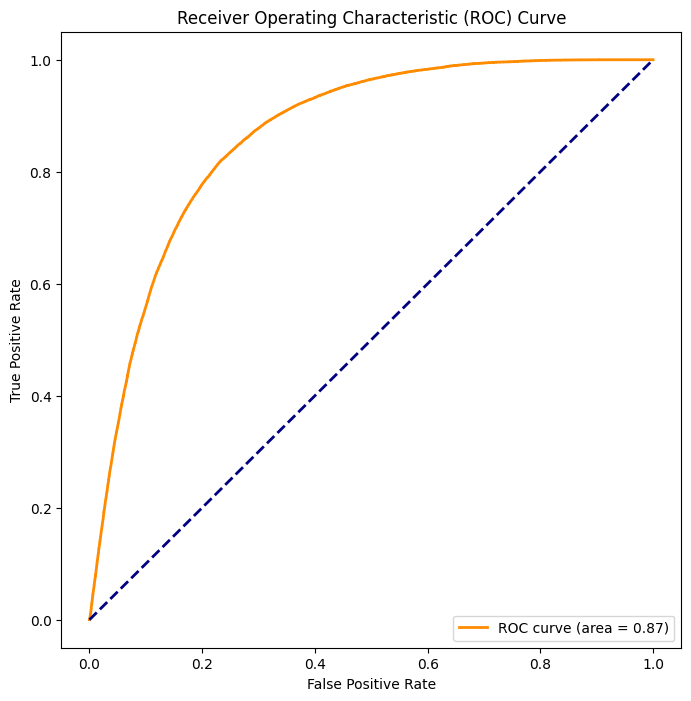

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


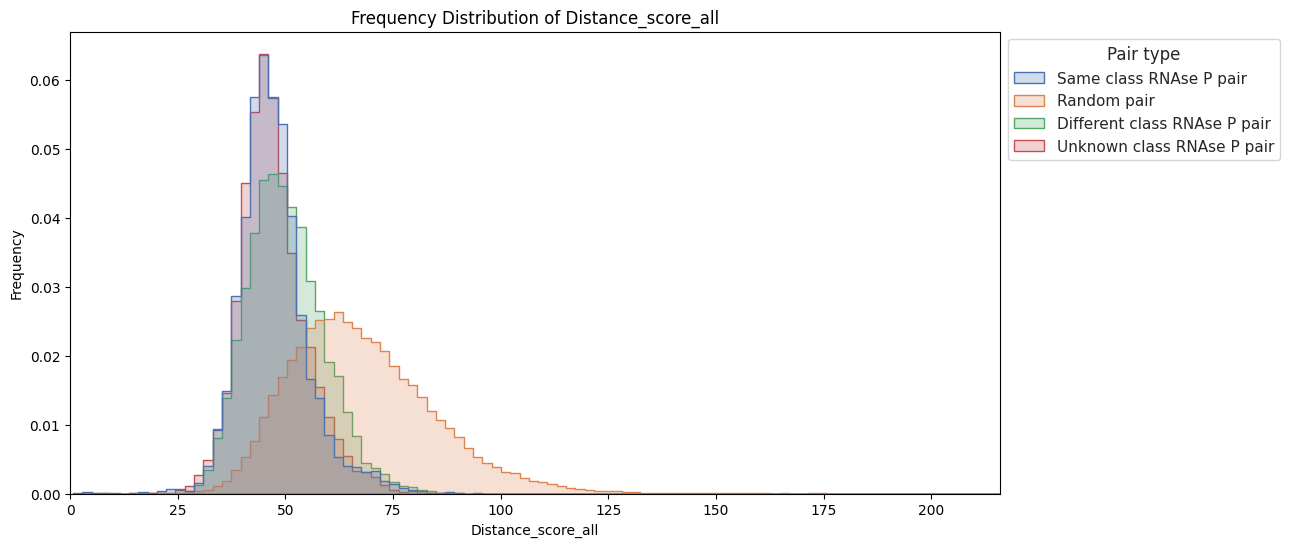

In [34]:
# Model evaluation for Square Distance

model_stadistics(metric='distance_score_all',
                 metric_type = 'distance',
                 RNA_type = 'RNP',
                 pairing_type = 'pair_class2',
                 f1_threshold=2.7,
                 df=results_sample)

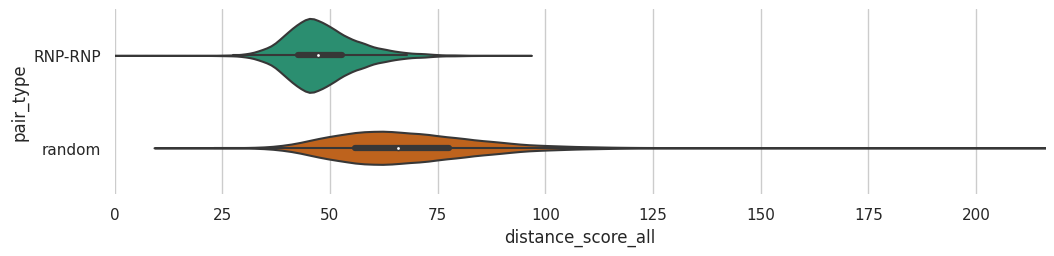

In [35]:
figsize = (12, 1.2 * len(results_sample['pair_type'].unique()))
plt.figure(figsize=figsize)
pair_order = ['Random pair', 'Different class RNAse P pair', 'Same class RNAse P pair', 'Unknown class RNAse P pair']
xlim = results_sample['distance_score_all'].max()
plt.xlim(0, xlim)
sns.violinplot(results_sample, x='distance_score_all', y='pair_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

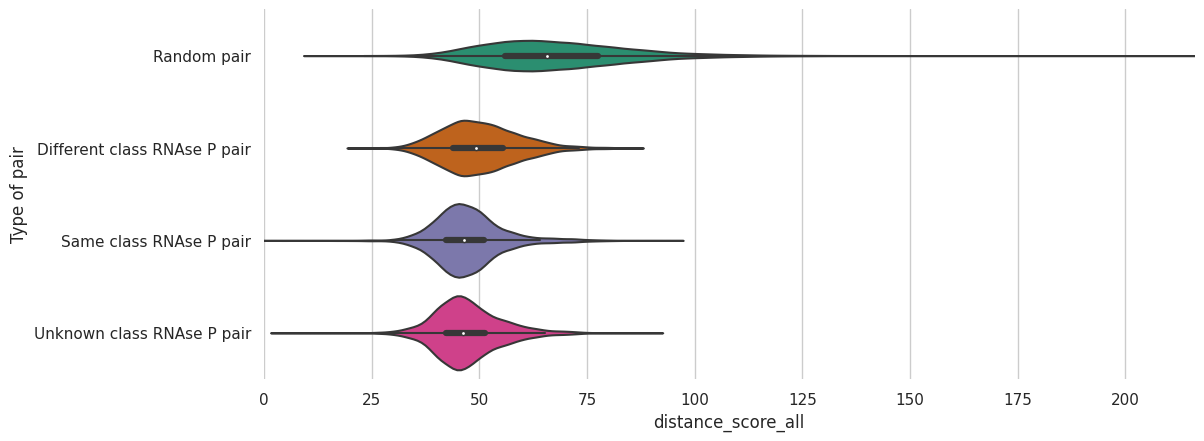

In [36]:
figsize = (12, 1.2 * len(results_sample['pair_class2'].unique()))
xlim = results_sample['distance_score_all'].max()
plt.figure(figsize=figsize)
pair_order = ['Random pair', 'Different class RNAse P pair', 'Same class RNAse P pair', 'Unknown class RNAse P pair']
plt.xlim(0, xlim)
sns.violinplot(results_sample, x='distance_score_all', y='pair_class2', inner='box', palette='Dark2', order = pair_order)
plt.ylabel("Type of pair")
sns.despine(top=True, right=True, bottom=True, left=True)

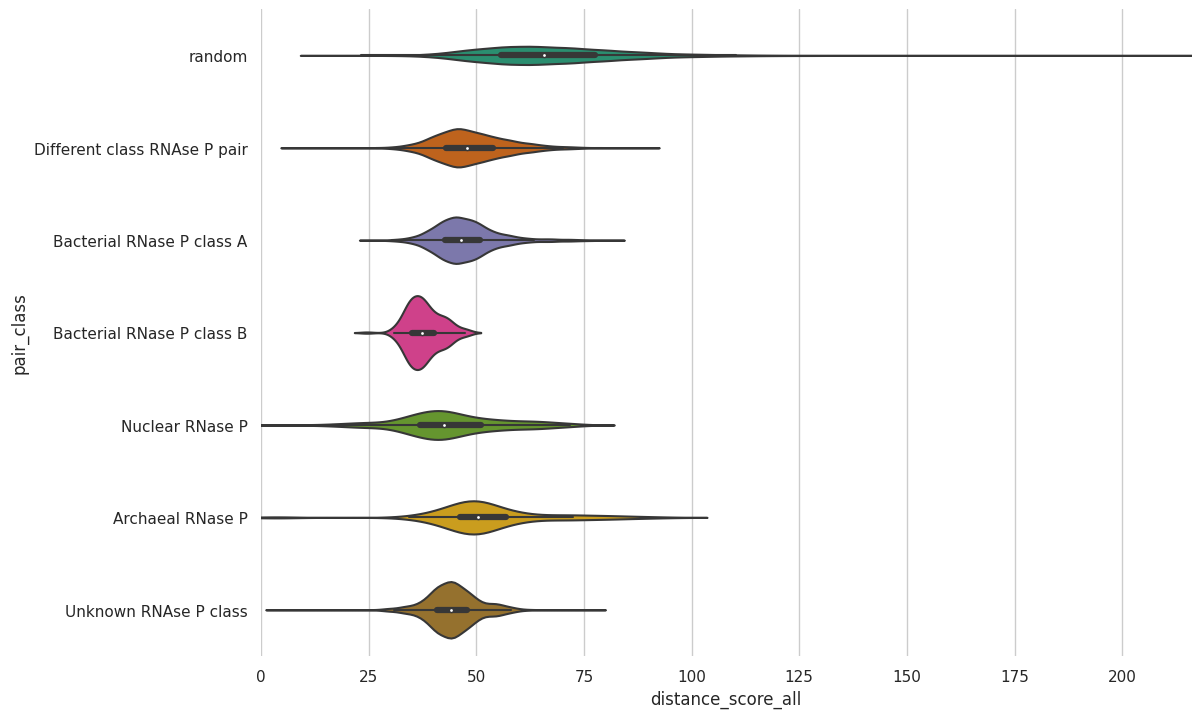

In [37]:
figsize = (12, 1.2 * len(results_sample['pair_class'].unique()))
plt.figure(figsize=figsize)
xlim = results_sample['distance_score_all'].max()

plt.xlim(0, xlim)
plt.ylabel("Type of pair")
pair_class_order = ['random', 'Different class RNAse P pair', 'Bacterial RNase P class A',
                    'Bacterial RNase P class B','Nuclear RNase P', 'Archaeal RNase P', 'Unknown RNAse P class']  
sns.violinplot(results_sample, x='distance_score_all', y='pair_class', inner='box', palette='Dark2', order=pair_class_order)

sns.despine(top=True, right=True, bottom=True, left=True)

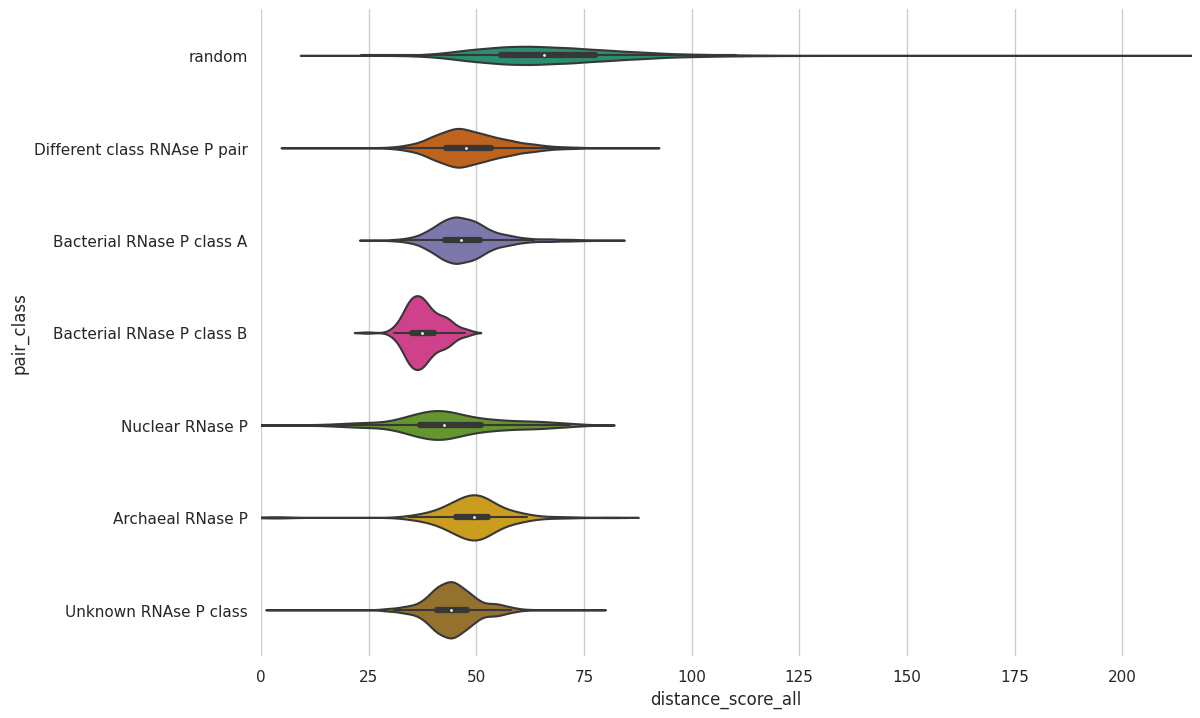

In [38]:
df_filtered = results_sample[(results_sample['rna_name_1'] != 'bpRNA_RNP_14') &
                             (results_sample['rna_name_2'] != 'bpRNA_RNP_14') &
                             (results_sample['rna_name_2'] != 'bpRNA_RNP_32') &
                             (results_sample['rna_name_2'] != 'bpRNA_RNP_32')]

figsize = (12, 1.2 * len(df_filtered['pair_class'].unique()))
plt.figure(figsize=figsize)
xlim = df_filtered['distance_score_all'].max()
plt.ylabel("Type of pair")

plt.xlim(0, xlim)
pair_class_order = ['random', 'Different class RNAse P pair', 'Bacterial RNase P class A',
                    'Bacterial RNase P class B','Nuclear RNase P', 'Archaeal RNase P', 'Unknown RNAse P class']  
sns.violinplot(df_filtered, x='distance_score_all', y='pair_class', inner='box', palette='Dark2', order=pair_class_order)
sns.despine(top=True, right=True, bottom=True, left=True)

In [39]:
# import numpy as np
# from scipy.cluster.hierarchy import linkage, dendrogram
# import matplotlib.pyplot as plt

# # Mapping dictionary
# class_mapping = {
#     'Bacterial RNase P class A': 'bacA',
#     'Bacterial RNase P class B': 'bacB',
#     'Nuclear RNase P': 'nucl',
#     'Archaeal RNase P': 'arch',
#     'Unknown RNAse P class' : 'unk',
#     'random' : 'rand'
# }

# # Create a new column based on the mapping
# results_sample['rna_class_1_short'] = results_sample['rna_class_1'].map(class_mapping)
# results_sample['rna_class_2_short'] = results_sample['rna_class_2'].map(class_mapping)

# # Extracting the desired part of the string
# results_sample['rna_name_1_short'] = results_sample['rna_name_1'].str.extract(r'(RNP_\d+|rna_\d+)')
# results_sample['rna_name_2_short'] = results_sample['rna_name_2'].str.extract(r'(RNP_\d+|rna_\d+)')
# results_sample['rna_name_class_1'] = results_sample['rna_class_1_short'] + '-' + results_sample['rna_name_1_short']
# results_sample['rna_name_class_2'] = results_sample['rna_class_2_short'] + '-' + results_sample['rna_name_2_short']

# # Get unique elements
# unique_elements = sorted(pd.concat([results_sample['rna_name_class_1'], results_sample['rna_name_class_2']]).unique())

# # Create an empty n x n matrix filled with NaN
# n = len(unique_elements)
# distance_matrix = np.full((n, n), np.nan)

# # Fill in the distance matrix with the distance scores
# for _, row in results_sample.iterrows():
#     i = unique_elements.index(row['rna_name_class_1'])
#     j = unique_elements.index(row['rna_name_class_2'])
#     distance_matrix[i, i] = 0
#     distance_matrix[i, j] = row['distance_score_all']
#     distance_matrix[j, i] = row['distance_score_all']  # Since it's a pairwise matrix, it's symmetric

# # Display the distance matrix
# distance_matrix_df = pd.DataFrame(distance_matrix, index=unique_elements, columns=unique_elements)

# distance_matrix_no_zeros = distance_matrix_df.replace(0, np.nan)
# min_row, min_col = distance_matrix_no_zeros.stack().idxmin()

# # Replace NaN values with the average of the entire DataFrame
# distance_matrix_df = distance_matrix_df.fillna(distance_matrix_df.stack().mean())

# # Mapping dictionary
# color_mapping = {
#     'Bacterial RNase P class A': 'pink',
#     'Bacterial RNase P class B': 'red',
#     'Nuclear RNase P': 'purple',
#     'Archaeal RNase P': 'orange',
#     'Unknown RNAse P class' : 'yellow',
#     'random' : 'green'
# }

# class_mapping = {
#     'Bacterial RNase P class A': 'bacA',
#     'Bacterial RNase P class B': 'bacB',
#     'Nuclear RNase P': 'nucl',
#     'Archaeal RNase P': 'arch',
#     'Unknown RNAse P class' : 'unk',
#     'random' : 'rand'
# }

# # Create a new column based on the mapping
# df['rna_color'] = df['rna_class'].map(color_mapping)
# df['rna_class_short'] = df['rna_class'].map(class_mapping)

# # Extracting the desired part of the string
# df['rna_name_short'] = df['rna_name'].str.extract(r'(RNP_\d+|rna_\d+)')
# df['rna_name_class'] = df['rna_class_short'] + '-' + df['rna_name_short']
# mapping_df = df[['rna_name_class','rna_color']].copy()

# rna_mapping_dict = dict(zip(mapping_df['rna_name_class'], mapping_df['rna_color']))

# # Generate hierarchical clustering SINGLE
# linkage_matrix = linkage(distance_matrix_df, method='single')

# plt.figure(figsize=(150, 150))
# plt.clf()

# ddata = dendrogram(linkage_matrix,
#                    color_threshold=1,
#                    labels=distance_matrix_df.index)

# # Assignment of colors to labels: 'a' is red, 'b' is green, etc.
# label_colors = rna_mapping_dict

# ax = plt.gca()
# xlbls = ax.get_xmajorticklabels()
# for lbl in xlbls:
#     lbl.set_color(label_colors[lbl.get_text()])

# plt.show()


# # Generate hierarchical clustering COMPLETE
# linkage_matrix = linkage(distance_matrix_df, method='complete')

# plt.figure(figsize=(150, 150))
# plt.clf()

# ddata = dendrogram(linkage_matrix,
#                    color_threshold=1,
#                    labels=distance_matrix_df.index)

# # Assignment of colors to labels: 'a' is red, 'b' is green, etc.
# label_colors = rna_mapping_dict

# ax = plt.gca()
# xlbls = ax.get_xmajorticklabels()
# for lbl in xlbls:
#     lbl.set_color(label_colors[lbl.get_text()])

# plt.show()